# Obs: Still working on it!

# Interactible notebook [here](https://colab.research.google.com/github/Vinnicius-Stein/Data-Science-and-AI/blob/master/Neural%20Networks/Neural%20Network%20with%20Logistic%20Regression/Neural%20Network%20with%20Logistic%20Regression%20from%20scratch.ipynb)

# FIRST OF ALL!
I'd like to thanks for Prof. Dr. Andrew Ng, DeepLearning.AI and Coursera for helping me to develop a Neural Network with Logistic Regression from scratch step-by-step.

 # Objective
 
 Build a Neural Network with logistic regression to predict if the given image is a cat (1) or not a cat (0). Neural Networks with logistic regression is considered a very simple neural network.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
import h5py

#data from a .h5 file
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Pre-processing Data

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


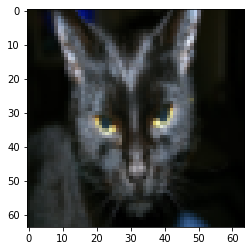

In [4]:
# Example of a picture
# change the index and re-run this cell to visualize other images. Try it!
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
#Overview from the dataset
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Each image is square (height = num_px) and (width = num_px)

In [6]:
##For convenience, I will now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px  ∗  num_px  ∗  3, 1). 
#After this, the training (and test) dataset is a numpy-array where each column represents a flattened image. 
#There should be m_train (respectively m_test) columns.

# Reshaping the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T # .T is the transposed matrix
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


Normalizing the array often leads to a better performance because gradient descent converges faster after normalization

In [7]:
#Standarzing the dataset dividing by 255 because each pixel from the image will be a maximum of 255 value (RGB value)
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# Getting started with the Neural Network implementation

## General Architecture of the learning algorithm ##

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$


where: <br>
X = Inputs <br>
      W = Weights, which given X determinates the weight/influence in the output multiplying and summing both (returning a           scalar)<br>
      b = Bias, a constant that garantees that every input will 'pass through' another neurons in Activation Function (Sigmoid)<br>
      Yhat = Probability of Y being 1 given the x<br>
      

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

**Summarizing key steps**:

    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of the algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

In [8]:
# Sigmoid function is the activation function that will return a value between 0 and 1. Z is a simple sum of 
# (Transposed W times X) plus b 
def sigmoid(z):
    
    s = 1 / (1 + np.exp(-z))
    
    return s

#testing the sigmoid output
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


Image that represents a Sigmoid function

<img src = "images/Sigmoid.png">

For convenience (for now), I will start weights and bias to 0. If all the weights are initialized with 0, the derivative with respect to loss function is the same for every w, thus all weights have the same value in subsequent iterations. So, by now, i'll initializate with 0's.

In [9]:
def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

#testing the function
dim = 3
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]]
b = 0


Forward Propagation:
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas I will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

Implementing the cost function and its gradient for the foward propagation<br>

A: sigmoid function applied in z which contains the activation.<br>
dw: gradient of the loss with respect to w (Derivative of W)<br>
db: gradient of the loss with respect to b (Derivative of b)<br>
cost: cost measures the performance of a Machine Learning model for given data. Cost Function quantifies the error between predicted values and expected values and presents it in the form of a single real number

In [10]:
def propagate(w, b, X, Y):
    #length of given dataset
    m = X.shape[1]
    
    A = sigmoid(np.dot((w.T),X) + b)
    cost = -(1/m)*np.sum((Y*np.log(A)) + ((1 - Y) * np.log(1 - A)))
   
    
    dw = np.dot((1/m), np.dot(X, (A-Y).T))
    db = np.dot((1/m), np.sum(A-Y))

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

#testing the function
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


The goal of optmization function is to learn 𝑤 and 𝑏 by minimizing the cost function by running the gradient descent algorithm.

In [11]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    #will be used as well to plot the learning curve
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieving derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Recording the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

#testing function
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b). y = 0 if 'a' less or equal 0.5 and y = 1 if 'a' bigger than 0.5. Y_prediction or Yhat is the list containing the 0's and 1's.

In [12]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot((w.T), X) + b)
    
    for i in range(A.shape[1]):
        
        # Converting probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i] <= 0.5:
            Y_prediction[0,i] = np.array(0)
        else:
            Y_prediction[0,i] = np.array(1)
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

#testing the function
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


# Merging all

Now, building the logistic regression model merging all the 'auxiliary functions'

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = True):
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w,b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    #Contain ALL information about the model
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


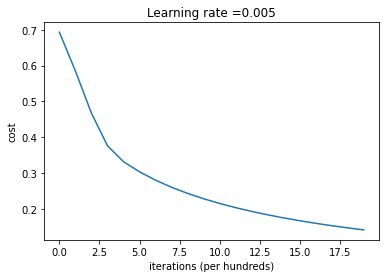

In [14]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()